In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### 1-初探数据

先加载训练数据，然后查看一下数据格式

In [29]:
data_train = pd.read_csv('data/train.csv')
data_test = pd.read_csv('data/test.csv')
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [30]:
data_train.info()
print('-'*40)
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null

我们看到，总共有12列，其中Survived字段表示的是该乘客是否获救，其余都是乘客的个人信息，包括：

| 字段名 | 含义 |
| ------ | ------ |
| PassengerId | 乘客ID |
| Pclass | 乘客等级(1/2/3等舱位)|
| Name | 乘客姓名|
| Sex | 性别|
| Age | 年龄|
| SibSp | 堂兄弟/妹个数|
| Parch | 父母与小孩个数|
| Ticket | 船票信息|
| Fare | 票价|
| Cabin | 客舱|
| Embarked | 登船港口|

但是很不幸，我们有些属性的数据不全：
- Age（年龄）缺失比较严重
- Cabin（客舱）缺失很严重
- Embarked 缺失不多
- Fare 缺失不多


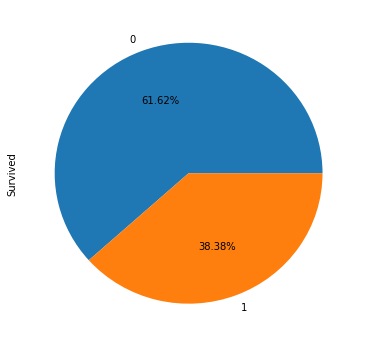

In [31]:
# 先看一下总体的生存比例
fig = plt.figure(figsize=(6,6))
data_train['Survived'].value_counts().plot.pie(autopct = '%1.2f%%')

### 2-缺失值处理
对数据进行分析的时候要注意其中是否有缺失值。

一些机器学习算法能够处理缺失值，比如神经网络，一些则不能。对于缺失值，一般有以下几种处理方法：

（1）如果数据集很多，但有很少的缺失值，可以删掉带缺失值的行；

（2）如果该属性相对学习来说不是很重要，可以对缺失值赋均值或者众数。比如在哪儿上船Embarked这一属性（共有三个上船地点），缺失俩值，可以用众数赋值


In [32]:
data_train['Embarked'][data_train['Embarked'].isnull()]
data_train['Embarked'][data_train['Embarked'].isnull()] = data_train['Embarked'].dropna().mode().values

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


（3）对于标称属性，可以赋一个代表缺失的值，比如‘U0’。因为缺失本身也可能代表着一些隐含信息。比如船舱号Cabin这一属性，缺失可能代表并没有船舱。 

In [33]:
data_train['Cabin'] = data_train['Cabin'].fillna('U0') 

（4）使用回归 随机森林等模型来预测缺失属性的值。因为Age在该数据集里是一个相当重要的特征（先对Age进行分析即可得知），所以保证一定的缺失值填充准确率是非常重要的，对结果也会产生较大影响。一般情况下，会使用数据完整的条目作为模型的训练集，以此来预测缺失值。对于当前的这个数据，可以使用随机森林来预测也可以使用线性回归预测。这里使用随机森林预测模型，选取数据集中的数值属性作为特征（因为sklearn的模型只能处理数值属性，所以这里先仅选取数值特征，但在实际的应用中需要将非数值特征转换为数值特征）


In [34]:
from sklearn.ensemble import RandomForestRegressor

age_df = data_train[['Age','Survived','Fare', 'Parch', 'SibSp', 'Pclass']]
age_df_notnull = age_df.loc[(data_train['Age'].notnull())]
age_df_isnull = age_df.loc[(data_train['Age'].isnull())]
X = age_df_notnull.values[:,1:]
Y = age_df_notnull.values[:,0]
# use RandomForestRegression to train data
RFR = RandomForestRegressor(n_estimators=1000,n_jobs=-1)
RFR.fit(X,Y)
predictAges = RFR.predict(age_df_isnull.values[:,1:])
data_train.loc[data_train['Age'].isnull(), ['Age']]= predictAges

In [37]:
# 接下来看一下补全后的数据
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          891 non-null object
Embarked       891 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


### 2-数据初步分析
每个乘客都这么多属性，那我们咋知道哪些属性更有用，而又应该怎么用它们。我们再深入一点来看看我们的数据，看看每个/多个 属性和最后的Survived之间有着什么样的关系呢。

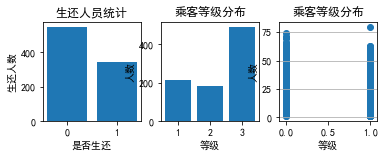

In [35]:
plt.rcParams['font.sans-serif'] = ['SimHei']
fig = plt.figure()
# 生还人数统计
ax1 = fig.add_subplot(231)
suvived_count = data_train['Survived'].value_counts()
plt.bar(suvived_count.index,suvived_count)
ax1.set_title('生还人员统计')
ax1.set_xlabel('是否生还')
ax1.set_ylabel('生还人数')

# 乘客等级分布
ax2 = fig.add_subplot(232)
pclass_count = data_train['Pclass'].value_counts()
plt.bar(pclass_count.index,pclass_count)
ax2.set_title('乘客等级分布')
ax2.set_xlabel('等级')
ax2.set_ylabel('人数')

# 乘客等级分布
ax3 = fig.add_subplot(233)
plt.scatter(data_train['Survived'],data_train['Age'])
plt.grid(b=True, which='major', axis='y') 
ax3.set_title('乘客等级分布')
ax3.set_xlabel('等级')
ax3.set_ylabel('人数')

plt.show()